# Tuần 1-2: Phân tích bài toán, tìm hiểu dataset, xây dựng baseline

In [26]:
%load_ext autoreload
%autoreload 2

from src.utils import download_data
from src.eda import *
from src.dataloader import load_captions_data
from src.preprocess import *
from src.train import *
from src.evaluate import Evaluator
import os


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Tải dữ liệu từ kaggle


In [27]:
download_data()

Data đã tồn tại


## 1. Phân tích dataset

In [28]:
if os.path.exists(Config.CAPTION):
    data = load_captions_data(Config.CAPTION)
else:
    print(f"LỖI: Không tìm thấy file tại {Config.CAPTION}")
    data = {}

# --- HIỂN THỊ CẤU TRÚC CỦA BIẾN DATA ---
if len(data) > 0:
    first_key = list(data.keys())[0]
    print(f"\nVí dụ cấu trúc biến 'data':")
    print(f"Key (Tên ảnh): {first_key}")
    print(f"Value (List Captions): {data[first_key]}")

Đang đọc file caption từ: ../data/flickr8k/captions.txt
Đã load xong dữ liệu của 8091 ảnh.

Ví dụ cấu trúc biến 'data':
Key (Tên ảnh): 1000268201_693b08cb0e.jpg
Value (List Captions): ['A child in a pink dress is climbing up a set of stairs in an entry way .', 'A girl going into a wooden building .', 'A little girl climbing into a wooden playhouse .', 'A little girl climbing the stairs to her playhouse .', 'A little girl in a pink dress going into a wooden cabin .']


1. Phân tích Caption

=== THỐNG KÊ ĐỘ DÀI CAPTION ===
total_captions: 40455.00
min_len: 1.00
max_len: 38.00
mean_len: 11.78
median_len: 11.00
std_dev: 3.89


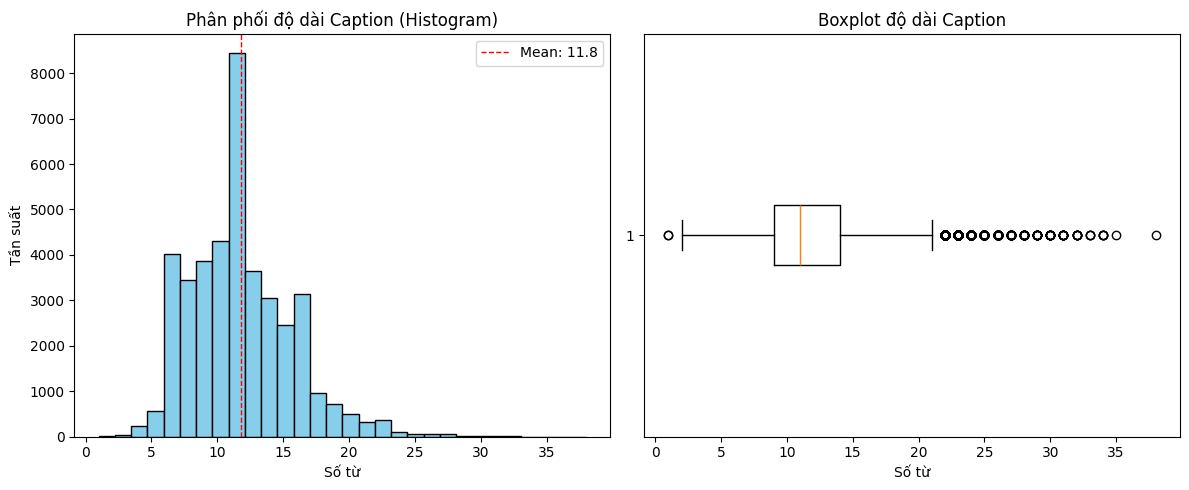

In [29]:
caption_stats = analyze_caption_lengths(data)

2. Phân tích Từ vựng

=== THỐNG KÊ TỪ VỰNG ===
Tổng số từ (Tokens): 436856
Kích thước từ điển (Unique words): 8911
Số từ chỉ xuất hiện 1 lần: 3676 (41.25%)


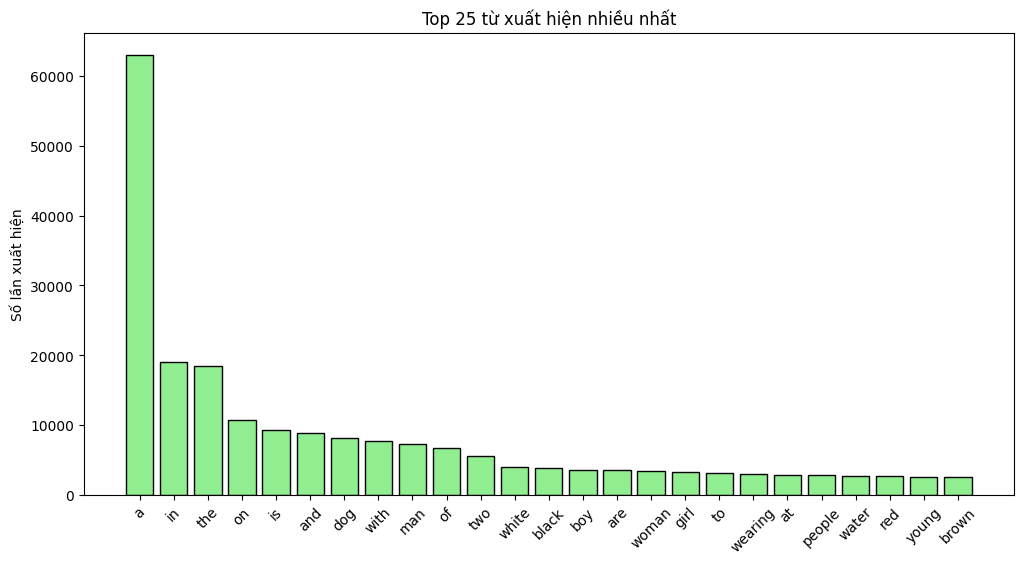

In [30]:
vocab_counter = analyze_vocabulary(data, top_n=25)

3. Phân tích Ảnh

Đang phân tích 8091 ảnh...


100%|██████████| 8091/8091 [00:05<00:00, 1513.22it/s]


=== THỐNG KÊ KÍCH THƯỚC ẢNH ===
Width  - Min: 164, Max: 500, Mean: 457.9
Height - Min: 127, Max: 500, Mean: 397.3


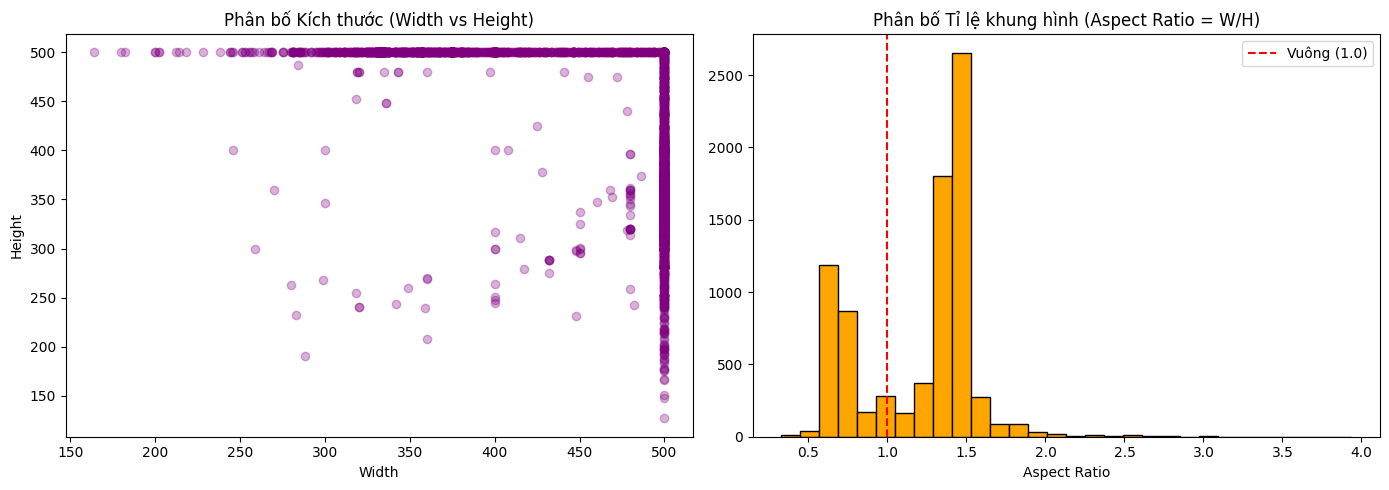

In [31]:
analyze_image_specs(data, Config.IMG_DIR, len(data))

4. Kiểm tra file

In [32]:
check_dataset_integrity(data, Config.IMG_DIR)

✅ Kiểm tra hoàn tất: Tất cả ảnh đều tồn tại.


[]

5. Xem ảnh mẫu

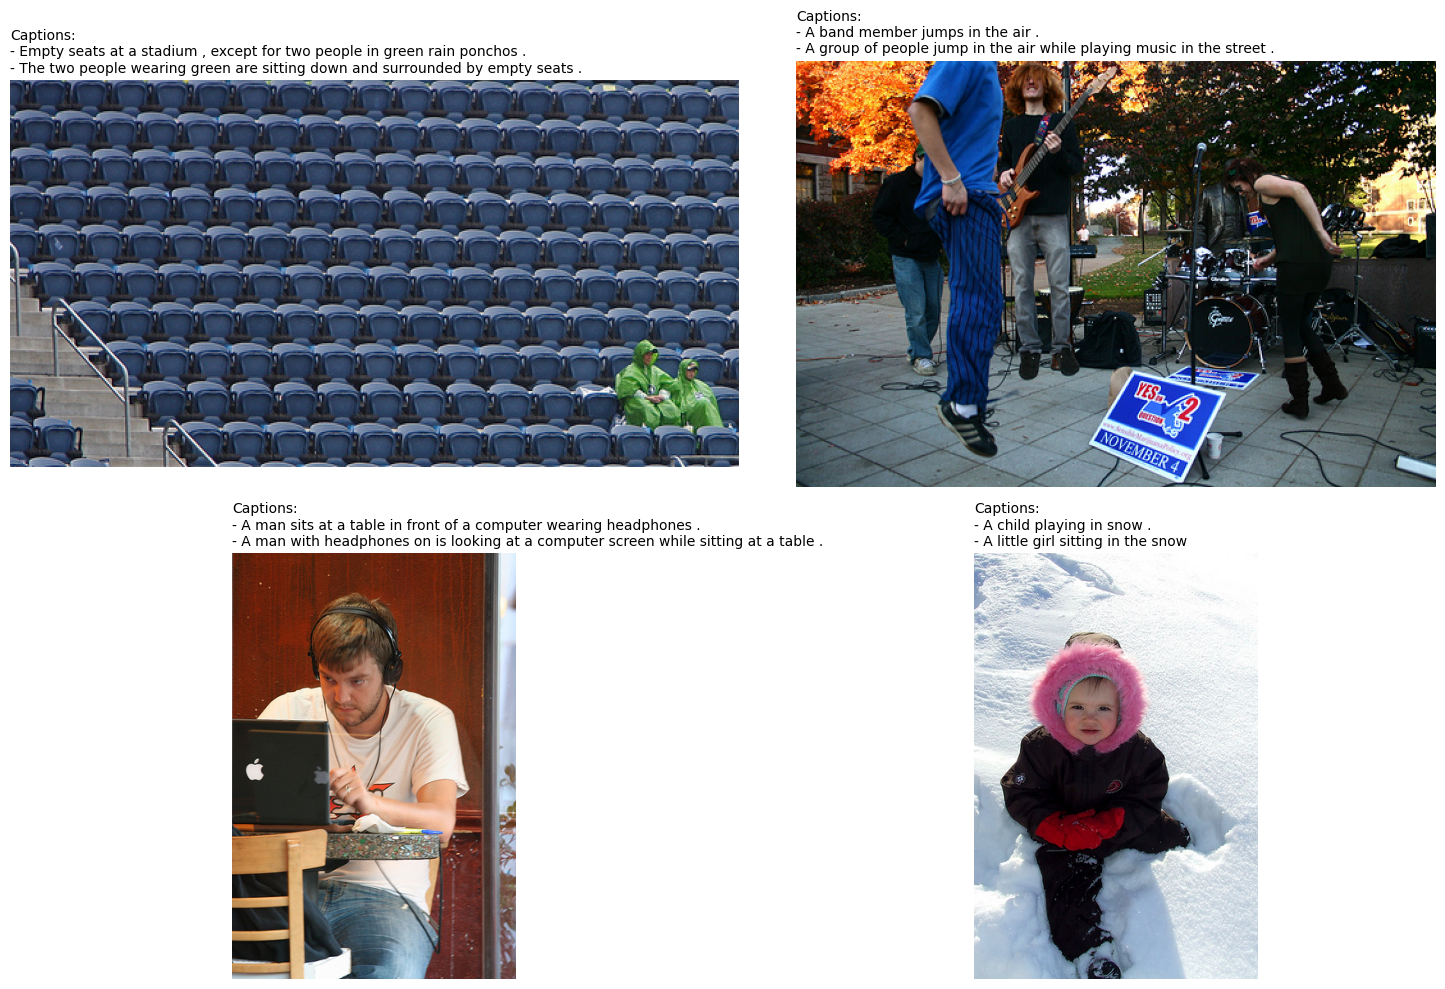

In [33]:
visualize_random_samples(data, Config.IMG_DIR, num_samples=4)

## 2. Tiền xử lý dữ liệu

In [34]:
train_loader, val_loader, test_loader, vocab = get_loaders(Config, data)

Vocabulary built! Size: 5231 words (Threshold: 2)
Data Split: Train=5663, Val=825, Test=1603 images


In [35]:
imgs, captions = next(iter(train_loader))
print(f"Images Shape: {imgs.shape}")
print(f"Captions Shape: {captions.shape}")

Images Shape: torch.Size([32, 3, 224, 224])
Captions Shape: torch.Size([32, 23])


In [36]:
sample_cap = captions[0]
print(f"Tensor: {sample_cap}")
print(f"Decoded: {vocab.denumericalize(sample_cap)}")

Tensor: tensor([   1,    4,   29,  516,    4,  221,   75,   13,    4, 1103, 1560,    2,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0])
Decoded: a dog catches a toy outside of a brick house


## 3. Xây dựng Model: CNN Encoder + LSTM Decoder

### a. CNN Encoder (ResNet-18 Pretrained)
- Sử dụng ResNet-18 pretrained trên ImageNet
- Loại bỏ FC layer cuối, thay bằng một fully connected layer để project feature về embedding size

### b. LSTM Decoder
- Nhận image embedding làm hidden state khởi tạo
- Sử dụng teacher forcing trong quá trình training
- Output: distribution over vocabulary tại mỗi timestep

Kiểm tra kiến trúc model

In [37]:
# Tạo dữ liệu giả
dummy_img = torch.randn(4, 3, 224, 224).to(Config.DEVICE) # Batch 4 ảnh
dummy_captions = torch.randint(0, 100, (4, 15)).to(Config.DEVICE) # Batch 4 câu, dài 15
# 2. Khởi tạo model
model = CNNtoRNN(
    embed_size=Config.EMBED_SIZE,
    hidden_size=Config.HIDDEN_SIZE,
    vocab_size=3000, # Giả sử vocab có 3000 từ
    num_layers=Config.NUM_LAYERS,
    train_cnn=Config.TRAIN_CNN,
    dropout=Config.DROPOUT
).to(Config.DEVICE)

# 3. Chạy thử Forward Pass
print("Running forward pass...")
outputs = model(dummy_img, dummy_captions)

print(f"Input Image: {dummy_img.shape}")
print(f"Input Caption: {dummy_captions.shape}")
print(f"Output Logits: {outputs.shape}")

# Kiểm tra kích thước output
# Mong đợi: [4, 14, 3000] (14 = 15 - 1 vì bỏ <EOS>)
expected_shape = (4, 14, 3000)

if outputs.shape == expected_shape:
    print("✅ MODEL SHAPE MATCH! Ready for training.")
else:
    print(f"❌ SHAPE MISMATCH! Expected {expected_shape}, got {outputs.shape}")

Running forward pass...
Input Image: torch.Size([4, 3, 224, 224])
Input Caption: torch.Size([4, 15])
Output Logits: torch.Size([4, 14, 3000])
✅ MODEL SHAPE MATCH! Ready for training.


In [ ]:
run_training(train_loader, val_loader, test_loader, vocab)

✅ Auto-save mode: Model sẽ được lưu tại:
   -> checkpoints/bs32_lr0.0003_emb256_20260127_2059.pth
Bắt đầu huấn luyện trên cpu...
Train batches: 885 | Val batches: 129

Epoch [1/10]


Train Loss: 8.4394:   1%|          | 10/885 [00:22<21:36,  1.48s/it] 

## 4. Đánh giá mô hình

In [ ]:


# 1. Load lại model tốt nhất
checkpoint_path = "checkpoints/bs32_lr0.0003_emb256_20260127_2030.pth" # Ví dụ
checkpoint = torch.load(checkpoint_path, map_location=Config.DEVICE)

# 2. Khởi tạo lại kiến trúc model
# Lưu ý: Phải dùng đúng vocab và tham số lúc train
model = CNNtoRNN(
    embed_size=Config.EMBED_SIZE,
    hidden_size=Config.HIDDEN_SIZE,
    vocab_size=len(vocab),
    num_layers=Config.NUM_LAYERS,
    train_cnn=Config.TRAIN_CNN,
    dropout=Config.DROPOUT
).to(Config.DEVICE)

# 3. Load trọng số (Weights)
model.load_state_dict(checkpoint['state_dict'])
print("✅ Model loaded successfully!")

# --- BẮT ĐẦU ĐÁNH GIÁ ---
evaluator = Evaluator(model, vocab, Config.DEVICE)

# Bước 1: Tính điểm số
evaluator.calculate_metrics(test_loader)

# Bước 2: Xem ảnh minh họa (Validation/Test)
evaluator.visualize(test_loader)

# Bước 3: Thử với ảnh ngoài
# evaluator.predict_image("test_image.jpg")